# Assignment 1

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [4]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [5]:
# Download necessary resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Load dataset
df = pd.read_csv(r"C:\Users\matth\Desktop\MSBA\BSAN 6200\Reviews.csv")

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [7]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [8]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None
                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817               

In [9]:
# Display the entire review text 
pd.set_option('display.max_colwidth', None)

In [10]:
# Add a new column for text length
df["Text_Length"] = df["Text"].astype(str).apply(len)

# Display descriptive statistics for text length
print(df["Text_Length"].describe())

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: Text_Length, dtype: float64


In [11]:
# Read a few random review samples
print(df["Text"].sample(10, random_state=45))

300665                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I have used this product before and found it to be the best product for jerk chicken. I could not find this product anywhere until my sister suggested I look on Amazon. There is nothing like it. It has a very unique taste.  I have tried other products out there and nothing compares to Busha Brownes Authentic Jerk Seasoning. I find myself wanting to go to jamaica and drink some rum and have jerk chicken.
167

In [12]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [13]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Handle missing values
    
    # 1. Remove HTML tags using a regex pattern
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags

    # 2. Replace URLs with a placeholder "URL"
    text = re.sub(r'http[s]?://\S+', 'URL', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Normalize whitespace (remove any leftover <br /> or extra spaces)
    text = re.sub(r"\s+", " ", text).strip()

    # 5. Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)

    # 6. Tokenize the text into words
    words = word_tokenize(text)

    # 7. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 8. Lemmatize the tokens
    cleaned_text = [lemmatizer.lemmatize(word) for word in words]

    # 9. Replace multiple spaces with a single space
    cleaned_text = " ".join(cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [14]:
# Select 100 random rows
random_sample = df.sample(100)

In [15]:
# Apply the updated cleaning function to the Text column
random_sample["Cleaned_Text"] = random_sample["Text"].apply(clean_text)

In [16]:
# Spot-checking
spotcheck_sample = random_sample[["Text", "Cleaned_Text"]].sample(5, random_state=45)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
40441                                                                                                                                                                                                                                                                                     I was very excited to receive this tea but was disappointed by the blossoms.  Don't buy this large size if you have never tried this brand.   
42809                                                                                                                                                 

## VADER

In [18]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Add negative words or phrases
custom_lexicon = {
    "meh": -0.5,
    "could be better": -0.3,
    "not great": -0.6,
    "disappointed": -0.8,
    "not happy": -0.7,
    "good product": 0.6,
    "love it": 0.8,
    "great taste": 0.7,
    "highly recommend": 0.9,
    "would buy again": 0.7,
    "favorite": 0.8,
    "best product": 0.9,
    "delicious": 0.8,
    "wonderful": 0.75,
    "impressed": 0.7,
    "good quality": 0.7,
    "pleasantly surprised": 0.6,
    "better than expected": 0.7,
    "amazing": 0.9,
    "perfect": 1.0,
    "satisfied": 0.6,
    "tasty": 0.7,
    "excited to try": 0.7,
    "nice texture": 0.6,
    "will buy again": 0.7
}

# Extend the lexicon
analyzer.lexicon.update(custom_lexicon)

In [20]:
# Tokenize the Cleaned_Text once and store it in a new column 'Tokens'
random_sample['Tokens'] = random_sample['Cleaned_Text'].apply(word_tokenize)

In [21]:
# Apply Feature Engineering on the pre-tokenized text
def extract_features_from_tokens(tokens):
    word_count = len(tokens)
    unique_word_count = len(set(tokens))
    avg_word_length = sum(len(word) for word in tokens) / word_count if word_count else 0

    # Sentiment analysis with VADER
    sentiment = analyzer.polarity_scores(" ".join(tokens))  # VADER expects a string, not tokens

    return [word_count, unique_word_count, avg_word_length, sentiment['compound']]

# Now apply the feature extraction on the 'Tokens' column (pre-tokenized)
random_sample[['Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']] = random_sample['Tokens'].apply(
    lambda x: pd.Series(extract_features_from_tokens(x)))

# Spot-check the results
print(random_sample[['Text', 'Cleaned_Text', 'Tokens', 'Word_Count', 'Unique_Word_Count', 'Avg_Word_Length', 'Sentiment_Score']].head())


In [22]:
def classify_sentiment(sentiment_score):
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification based on VADER sentiment score
random_sample['Sentiment_Label'] = random_sample['Sentiment_Score'].apply(classify_sentiment)

# Show some of the classified sentiments
print(random_sample[['Cleaned_Text', 'Sentiment_Score', 'Sentiment_Label']].head())

In [23]:
# Extract sentiment predictions from VADER
random_sample['VADER_Sentiment'] = random_sample['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral'
)

In [24]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text', 'VADER_Sentiment']].sample(5, random_state=45)

print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                 Text  \
40441                                                                                                                                                                                                                                                                                     I was very excited to receive this tea but was disappointed by the blossoms.  Don't buy this large size if you have never tried this brand.   
42809                                                                                                                                                 

In [25]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print("-" * 50)

Review Text: I was very excited to receive this tea but was disappointed by the blossoms.  Don't buy this large size if you have never tried this brand.
VADER Sentiment: Positive
--------------------------------------------------
Review Text: This organic chocolate is absolutely delicious...so smooth and creamy.  There is a rich, deep chocolate taste and excellent texture...not waxey or grainy at all, with just the right amount of sweetness.  Chocoholics...this is the one for you.  Fabulous!
VADER Sentiment: Positive
--------------------------------------------------
Review Text: This flavor is the best of the bunch by far.  I am reluctantly on a diet that allows for a few almonds as a snack.  I tried these and I was hooked.  Unfortunately, most stores do not carry this flavor.  My first case went very quickly, as every co-worker who tried them wanted a can of their own.  I recommend them to anyone, not only those of us trying to stick to a diet that deprives us of less healthy snacks.

## TextBlob

In [27]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity, 'Positive' if blob.sentiment.polarity > 0 else ('Negative' if blob.sentiment.polarity < 0 else 'Neutral')

# Apply the function and append new columns
random_sample[['TextBlob_Polarity', 'TextBlob_Subjectivity', 'TextBlob_Sentiment']] = random_sample['Cleaned_Text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display the updated DataFrame
random_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Tokens,Word_Count,Unique_Word_Count,Avg_Word_Length,Sentiment_Score,Sentiment_Label,VADER_Sentiment,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Sentiment
40441,40442,B000FFS0CA,A1M5D0DG09UGVM,Bonne Maman,1,2,2,1185494400,Not Pretty,I was very excited to receive this tea but was disappointed by the blossoms. Don't buy this large size if you have never tried this brand.,...,"[excited, receive, tea, disappointed, blossom, dont, buy, large, size, never, tried, brand]",12.0,12.0,5.583333,0.1531,Positive,Positive,-0.053571,0.642857,Negative
42809,42810,B002NHYQAS,A3SFLH7RUH873G,"Amazon Fan ""AF""",0,0,5,1298419200,"Delicious, Smooth Chocolate!","This organic chocolate is absolutely delicious...so smooth and creamy. There is a rich, deep chocolate taste and excellent texture...not waxey or grainy at all, with just the right amount of sweetness. Chocoholics...this is the one for you. Fabulous!",...,"[organic, chocolate, absolutely, deliciousso, smooth, creamy, rich, deep, chocolate, taste, excellent, texturenot, waxey, grainy, right, amount, sweetness, chocoholicsthis, one, fabulous]",20.0,19.0,7.350000,0.9313,Positive,Positive,0.380102,0.726531,Positive
401512,401513,B000Q611U6,A3KZCNV1N8R9GC,diljs,0,0,4,1222646400,"Like a Tasty Organic Twizzler, way better than other so called ""Fruit Snacks""","The Clif Kids Twisted Fruit rope is a great product. It can replace those nasty ""fruit flavored"" roll ups and ""fruit snacks"" that are made primarily of corn syrup and artificial color and usually no fruit at all. The twisted fruit rope is made out of actual furit, and even provides one serving per rope. The ingredients are simple: apple puree, apple juice concentrate (makes it sweet), flavors, pectin, and fruit and vegetable colorings. None of the chemicals from those bright ""fruit flavored"" concoctions, and everything is organic!<br /><br />The taste is great, too. It's a bit tart, but with a nice berry flavor. The texture is chewy, and it looks, tastes, and feels like a big Twizzler. The ropes are packaged individually to throw in lunch boxes or backpacks, but I found myself reaching for at least 2 at a time.<br /><br />There are a couple of things I didn't like. The strips are a little sticky; it helps if you hold them by the wrapper instead of taking them out. The sugar is also still fairly high. There are 9 grams of sugar, a whopping 45% out of each 20 gram rope. It's not added refined sugar, but the sugar comes from apple juice concentrate, which is much sweeter than natural apple juice. Combine that with the sticky nature of the product and it's probably a good idea to have your kids rinse their teeth after eating one.<br /><br />Those drawbacks aside, these snacks remain far superior to candy or those gooey little ""fruit snacks"" as a tasty treat for kids (or adults!). Keep in mind actual fruit is always a better choice, but if you need something portable, these are a great option.",...,"[clif, kid, twisted, fruit, rope, great, product, replace, nasty, fruit, flavored, roll, ups, fruit, snack, made, primarily, corn, syrup, artificial, color, usually, fruit, twisted, fruit, rope, made, actual, furit, even, provides, one, serving, per, rope, ingredient, simple, apple, puree, apple, juice, concentrate, make, sweet, flavor, pectin, fruit, vegetable, coloring, none, chemical, bright, fruit, flavored, concoction, everything, organicthe, taste, great, bit, tart, nice, berry, flavor, texture, chewy, look, taste, feel, like, big, twizzler, rope, packaged, individually, throw, lunch, box, backpack, found, reaching, least, timethere, couple, thing, didnt, like, strip, little, sticky, help, hold, wrapper, instead, taking, sugar, also, still, fairly, high, ...]",157.0,119.0,5.649682,0.9844,Positive,Positive,0.124464,0.583827,Positive
384274,384275,B0018LB76Q,A2GPP8QIF8HHKO,TC,0,0,2,1326672000,Dissapointed,"I have bought hot pepper 

In [28]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text','VADER_Sentiment', 'TextBlob_Sentiment']].sample(5)
print(spotcheck_sample)

In [29]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: *****<br /><br />Numi Tea's Chinese Breakfast Yunnan Black Tea is a premium Numi tea, both certified organic and kosher. The only ingredient is fair trade certified organic high mountain Yunnan Black Tea FOP (Flowery Orange Pekoe). There is nothing artificial in this or in any Numi tea.<br /><br />On the box, the manufacturer writes: "This noble tea is grown in the mist covered mountains of Yunnan province. What distinguishes this fine, organic black tea is its perfect sense of balance, exquisite tiger's eye color, and a lean vibrancy which makes it suitable at any time of day. Like a complex wine, it is the perfect tea for food, marrying well with a wide variety of dishes. It has a distant and hard to place floral quality, yet it leaves the mouth tasting as clean as spring water. And it energizes the body and mind more harmoniously than the best of coffees. We are proud to bring you this high grade leaf."<br /><br />Although this tea says "orange pekoe", it does not taste

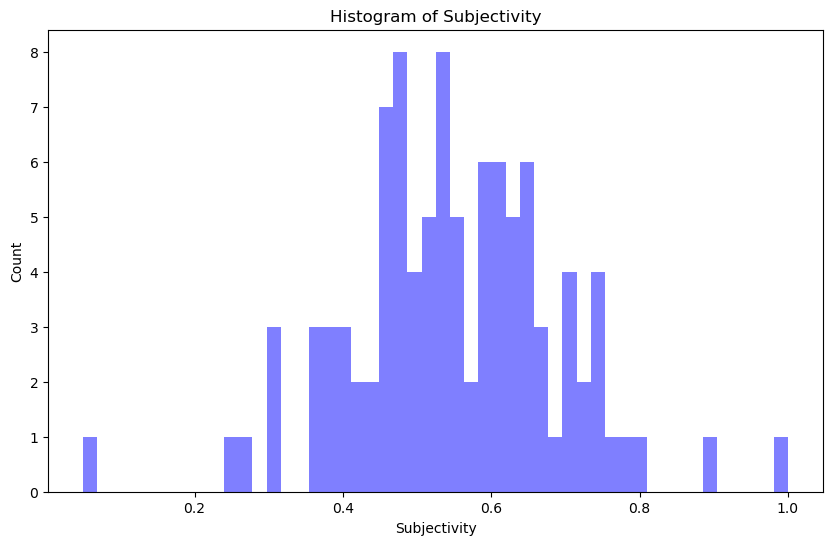

In [30]:
#Draw a histogram that shows the distribution of subjectivity: Count vs. subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show()

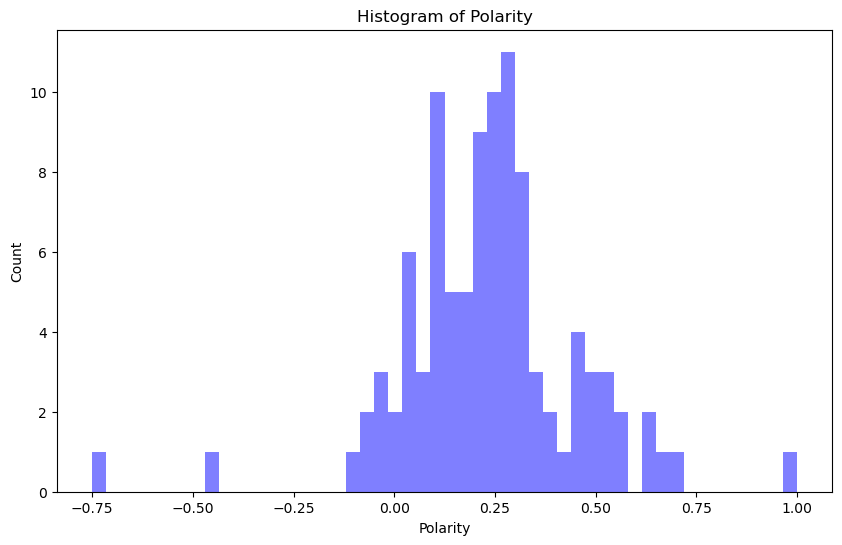

In [31]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()